# 📗 Notebook 03 – Reactive One-Port Elements: Capacitor

## 1. Objective

This notebook introduces the capacitor as a reactive one-port component within the Wave Digital Filter (WDF) framework.

We will:

- Derive the wave-domain equations from the classical capacitor model
- Apply the trapezoidal rule to discretize its behavior
- Identify its adapted port resistance
- Explain how `pywdf.Capacitor` implements these concepts
- Simulate its behavior in response to different waveforms

## 2. Capacitor in the Kirchhoff Domain

In the time domain, an ideal capacitor is defined by:

$$
i(t) = C \frac{dv(t)}{dt}
$$

Where:

- $i(t)$ is the current through the capacitor
- $v(t)$ is the voltage across its terminals
- $C$ is the capacitance in Farads

This is a differential equation, which cannot be used directly in a digital system without discretization.

## 3. Discretization: Trapezoidal Rule

To express this behavior in discrete time, we use the trapezoidal integration rule (a second-order approximation):

$$
v[n] = v[n-1] + \frac{T}{2C} (i[n] + i[n-1])
$$

Rewriting it to resemble a resistive form, we obtain an expression for an equivalent port resistance:

$$
R_p = \frac{1}{2 C f_s}
$$

Where:

- $f_s$ is the sampling rate
- $T = \frac{1}{f_s}$

This allows the capacitor to be modeled as an adapted WDF one-port with a known (passive) port resistance.

## 4. Wave Variable Definitions

In WDF, we work with wave variables instead of direct voltages and currents:

**Incident wave:**

$$
a[n] = v[n] + R_p \cdot i[n]
$$

**Reflected wave:**

$$
b[n] = v[n] - R_p \cdot i[n]
$$

These are invertible:

$$
v[n] = \frac{a[n] + b[n]}{2}, \quad i[n] = \frac{a[n] - b[n]}{2 R_p}
$$

## 5. Wave-Domain Behavior of the Capacitor

From Kurt James Werner’s dissertation (Eq. 1.33, p. 25), the adapted capacitor behaves as:

$$
b[n] = z[n - 1]
$$

Where $z[n]$ is an internal state updated at each time step:

$$
z[n] = a[n]
$$

This means the capacitor reflects the previous incident wave — a memory effect consistent with physical energy storage.

## 6. pywdf Implementation

The `pywdf` library implements this adapted behavior directly. The key elements in `Capacitor.__init__` are:

```python
self.Rp = 1.0 / (2 * self.C * self.fs)
```

And the wave behavior is:

```python
def accept_incident_wave(self, a):
    self.a = a
    self.z = self.a  # store current a[n]

def propagate_reflected_wave(self):
    self.b = self.z  # return a[n-1]
    return self.b
```

This implements:

$$
b[n] = a[n - 1]
$$


## Capacitor – Impulse Response (Discrete-Time Simulation)

To visualize how a capacitor behaves in the wave domain, we drive it with a **discrete-time impulse**.

A capacitor has memory, meaning the reflected wave $b[n]$ depends on its internal state $z[n]$:

$$
b[n] = z[n], \quad z[n] \leftarrow a[n]
$$

We use the `pywdf.Capacitor` class, which internally updates $z[n]$ on each call to `accept_incident_wave`.

We apply an impulse to the port (i.e., $a[0] = 1$, $a[n > 0] = 0$) and observe the evolution of:

- Reflected wave $b[n]$
- Port voltage $v[n] = a[n] + b[n]$
- Port current $i[n] = \dfrac{a[n] - b[n]}{R_0}$


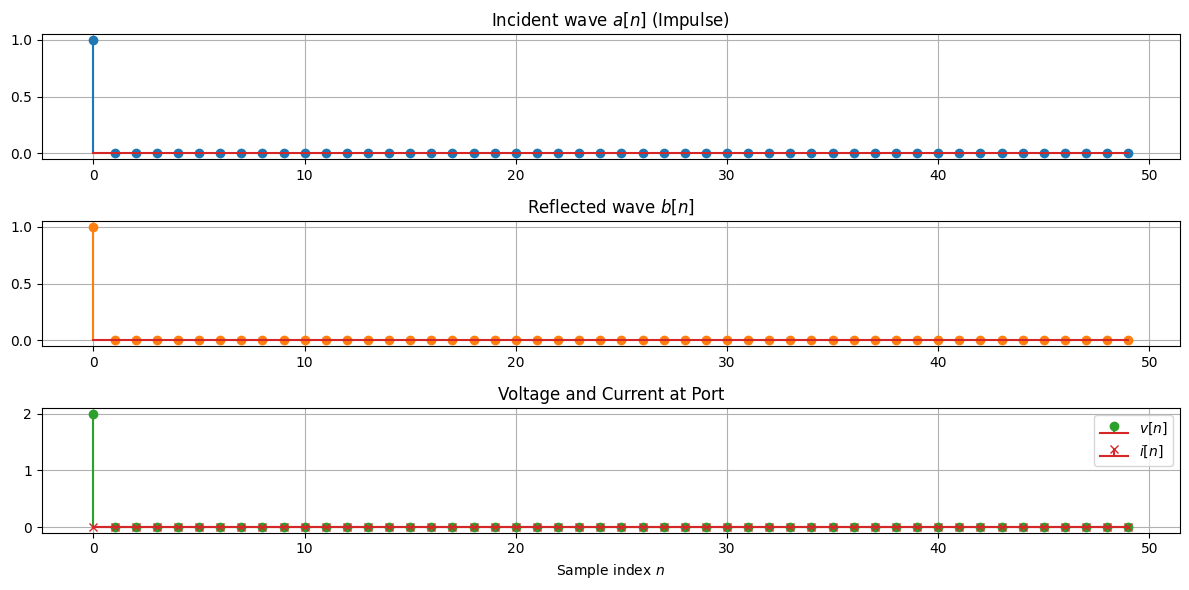

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pywdf.core.wdf import Capacitor

# Parameters
fs = 48000       # Sample rate
N = 50           # Number of samples
C_val = 1e-6     # Capacitance
R0 = 1.0         # Port resistance

# Create capacitor
C = Capacitor(C=C_val, fs=fs)

# Impulse input
a_vals = np.zeros(N)
a_vals[0] = 1.0  # Unit impulse

# Initialize output arrays
b_vals = np.zeros(N)
v_vals = np.zeros(N)
i_vals = np.zeros(N)

# Simulate
for n in range(N):
    C.accept_incident_wave(a_vals[n])
    b_vals[n] = C.propagate_reflected_wave()
    v_vals[n] = a_vals[n] + b_vals[n]
    i_vals[n] = (a_vals[n] - b_vals[n]) / R0

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
plt.stem(a_vals)
plt.title("Incident wave $a[n]$ (Impulse)")
plt.grid()

plt.subplot(3,1,2)
plt.stem(b_vals, linefmt='C1-', markerfmt='C1o')
plt.title("Reflected wave $b[n]$")
plt.grid()

plt.subplot(3,1,3)
plt.stem(v_vals, linefmt='C2-', markerfmt='C2o', label="$v[n]$")
plt.stem(i_vals, linefmt='C3--', markerfmt='C3x', label="$i[n]$")
plt.title("Voltage and Current at Port")
plt.xlabel("Sample index $n$")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


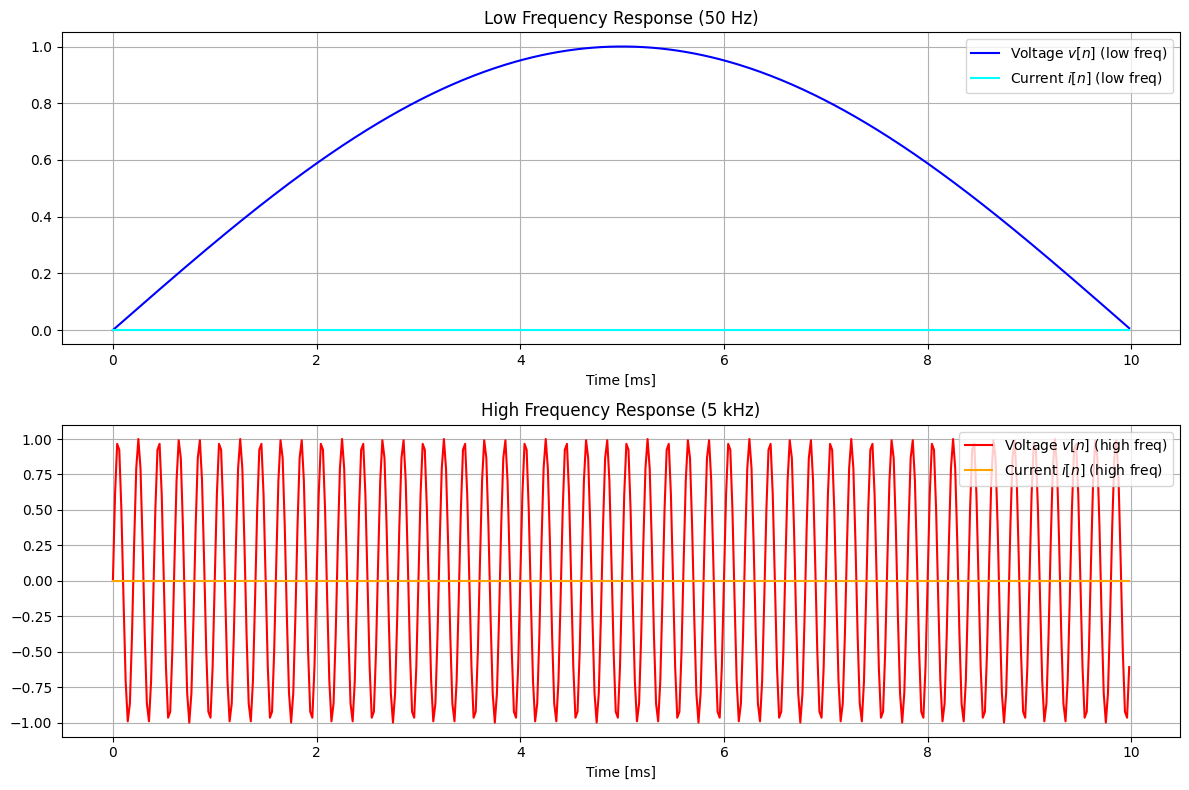

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pywdf.core.wdf import Capacitor

# Sampling settings
fs = 48000
t = np.linspace(0, 0.01, int(fs * 0.01), endpoint=False)  # 10 ms

# Frequencies
f_low = 50      # Hz
f_high = 5000   # Hz

# Input signals (amplitude = 1.0)
v_low = np.sin(2 * np.pi * f_low * t)
v_high = np.sin(2 * np.pi * f_high * t)

# Create capacitor
C_value = 1e-6
cap = Capacitor(C_value, fs)
R0 = cap.Rp  # Extract internal port resistance

# Simulate low freq
a_vals_low, b_vals_low, v_vals_low, i_vals_low = [], [], [], []

for v_in in v_low:
    # Convert input voltage to wave variable
    # Using a = v + R0 * i, but since we control v only, we set:
    # Let i = 0 → a = v (initial assumption for wave injection)
    a = v_in
    cap.accept_incident_wave(a)
    b = cap.propagate_reflected_wave()

    # Inverse transformation
    v = 0.5 * (a + b)
    i = 0.5 * (a - b) / R0

    a_vals_low.append(a)
    b_vals_low.append(b)
    v_vals_low.append(v)
    i_vals_low.append(i)

# Simulate high freq
cap.reset()
a_vals_high, b_vals_high, v_vals_high, i_vals_high = [], [], [], []

for v_in in v_high:
    a = v_in
    cap.accept_incident_wave(a)
    b = cap.propagate_reflected_wave()

    v = 0.5 * (a + b)
    i = 0.5 * (a - b) / R0

    a_vals_high.append(a)
    b_vals_high.append(b)
    v_vals_high.append(v)
    i_vals_high.append(i)

# Plot
plt.figure(figsize=(12, 8))

# Low freq
plt.subplot(2, 1, 1)
plt.plot(t * 1000, v_vals_low, label=r'Voltage $v[n]$ (low freq)', color='blue')
plt.plot(t * 1000, i_vals_low, label=r'Current $i[n]$ (low freq)', color='cyan')
plt.title("Low Frequency Response (50 Hz)")
plt.xlabel("Time [ms]")
plt.grid(True)
plt.legend()

# High freq
plt.subplot(2, 1, 2)
plt.plot(t * 1000, v_vals_high, label=r'Voltage $v[n]$ (high freq)', color='red')
plt.plot(t * 1000, i_vals_high, label=r'Current $i[n]$ (high freq)', color='orange')
plt.title("High Frequency Response (5 kHz)")
plt.xlabel("Time [ms]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

